In [1]:
# import community
import numpy as np
import networkx as nx
import matplotlib as mpl
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.image as mpimg
import graphviz
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import random
import pydoc
from ds import McmcTree as Tree
from utils import ColorPrint as _

import sys
sys.path.append("..")
from datasets.synthetic.generator import TreeGenerator

font = {'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [2]:
def pairwise_anc_error(T_gt, T_pd):

    nodes = T_gt.nodes()
    root = [n for n,d in gt_T.in_degree() if d==0][0]

    gt_paths = []
    for node in T_gt:
        gt_paths.append(nx.shortest_path(T_gt, root, node))

    pd_paths = []
    for node in T_pd:
        pd_paths.append(nx.shortest_path(T_pd, str(root), str(node)))
    pd_paths = list(list(int(e) for e in l) for l in pd_paths)

    res = []
    for n1 in nodes:
        for n2 in nodes:
            if n2 <= n1: continue
            if n2 in T_gt.neighbors(n1) and str(n2) in T_pd.neighbors(str(n1)): #n1 -> n2
                res.append(0)
            elif n1 in T_gt.neighbors(n2) and str(n1) in T_pd.neighbors(str(n2)): #n2 -> n1
                res.append(0)
            elif n2 in T_gt.neighbors(n1) or str(n2) in T_pd.neighbors(str(n1)): # ops n1 -> n2
                res.append(1)
            elif n1 in T_gt.neighbors(n2) or str(n1) in T_pd.neighbors(str(n2)): # ops n2 -> n1
                res.append(1)
            else:
                gt_same_branch = [1 for path in gt_paths if (n1 in path and n2 in path)]
                pd_same_branch = [1 for path in pd_paths if (n1 in path and n2 in path)]

                if bool(gt_same_branch) == bool(pd_same_branch):
                    res.append(0)
                else:
                    res.append(1)

    return sum(res)/len(res)

### The effect of changing $N$ for fixed $M$

In [3]:
M, N = 10, 20
ZETA = 1
Gamma = 0.15
alpha = 6*1e-6
beta = 0.15
MR = 0.00


all_result = []
for N in [10, 15, 20, 30, 50, 80]:
    means_pwd = []
    best_engs = []
    varia_pwd = []
    pwae = []
    print(f'started with params: M={M}, N={N}')
    for rond in range(7):
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
        gensNames = list( str(i) for i in range(M) )
        C_num = D.shape[1]
        G_num = D.shape[0]
#         _.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        ### Fill missed data
        def tf(m,c):
            os = len(np.where(D[:,c]==1.))*1.
            zs = len(np.where(D[:,c]==0.))*1.
            return 1. if np.random.rand() < os/(os+zs) else 0.

        for m in range(G_num):
            for c in range(C_num):
                if D[m,c] == 3.:
                    D[m,c] = tf(m,c)
        ### Run
        dl = list(d for d in D)
        root = [n for n,d in gt_T.in_degree() if d==0][0]
#         print('ROOT:', root)
        T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
        T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)
        T.randomize()
        # T.plot_best_T('initial T'); T.plot('T0')
        T.set_rho(15)
        for i in range(5000):
            if T.next():
                break
                
        ###  Benchmarking
        pwae.append(pairwise_anc_error(T.gt_T, T.get_best_tree()))
        best_T = T.get_best_tree()
        best_g = best_T.to_undirected()
        gt_T = T.gt_T
        gt_T = gt_T.to_undirected()
        best_pair_dists = dict(nx.all_pairs_shortest_path_length(best_g))
        gt_pair_dists   = dict(nx.all_pairs_shortest_path_length(gt_T  ))
        diffs = []
        for i in range(M-1):
            for j in range(i+1, M):
                best_dis = best_pair_dists[str(i)][str(j)]
                gt_dis   = gt_pair_dists  [i][j]
                diff = abs(best_dis - gt_dis)
                diffs.append(diff)
        means_pwd.append(np.mean(diffs))
        varia_pwd.append(np.var(diffs))
        best_engs.append(T.get_best_error())
        print(f'\trond={rond}, mean_pwd={means_pwd[-1]:0.4f}, varia_pwd={varia_pwd[-1]:0.4f}, best_eng={best_engs[-1]:0.4f}')
        
    all_result.append({
        'params': {
            'M':M,
            'N':N, 
            'ZETA':ZETA,
            'Gamma':Gamma,
            'alpha':alpha,
            'beta':beta,
            'MR':MR,
        },
        'means_pwd': means_pwd,
        'varia_pwd': varia_pwd,
        'best_engs': best_engs,
        'pwae': pwae
    })
    print(38*'-~')
    print(f'\tAVG_mean_pwd={np.mean(means_pwd):0.4f}, AVG_varia_pwd={np.mean(varia_pwd):0.4f}, AVG_best_eng={np.mean(best_engs):0.4f}, AVG_pwae={np.mean(pwae):0.4f}\n\n')
#     T.plot_eng_chart()

started with params: M=10, N=10
	rond=0, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=49.2692
	rond=1, mean_pwd=0.4667, varia_pwd=0.2489, best_eng=94.5617
	rond=2, mean_pwd=0.2000, varia_pwd=0.1600, best_eng=61.3320
	rond=3, mean_pwd=0.6889, varia_pwd=0.3477, best_eng=58.4707
	rond=4, mean_pwd=0.2000, varia_pwd=0.1600, best_eng=82.6122
	rond=5, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=32.2549
	rond=6, mean_pwd=0.8000, varia_pwd=0.4267, best_eng=67.8582
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.3873, AVG_varia_pwd=0.2246, AVG_best_eng=63.7656, AVG_pwae=0.1492


started with params: M=10, N=15
	rond=0, mean_pwd=0.8444, varia_pwd=0.5314, best_eng=123.6458
	rond=1, mean_pwd=0.8667, varia_pwd=1.4933, best_eng=63.9219
	rond=2, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=94.1784
	rond=3, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=127.3069
	rond=4, mean_pwd=1.2000, varia_pwd=4.1600, best_eng=94.1784
	rond=5, mean_pwd=0.3556, varia_pwd=0.229

/home/afshin/Desktop/itmt/src/ds.py:639: RuntimeWarning: divide by zero encountered in log
  np.log(self.alpha**fp_cnt + ep)


	rond=0, mean_pwd=0.5333, varia_pwd=0.2489, best_eng=453.3527
	rond=1, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=227.6572
	rond=2, mean_pwd=0.6889, varia_pwd=0.3477, best_eng=311.5484
	rond=3, mean_pwd=0.4667, varia_pwd=0.2489, best_eng=210.0312
	rond=4, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=331.0374
	rond=5, mean_pwd=0.6222, varia_pwd=0.8573, best_eng=506.1915
	rond=6, mean_pwd=0.6222, varia_pwd=0.3240, best_eng=337.2162
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.5206, AVG_varia_pwd=0.3550, AVG_best_eng=339.5764, AVG_pwae=0.1714


started with params: M=10, N=50


/home/afshin/Desktop/itmt/src/ds.py:382: RuntimeWarning: invalid value encountered in double_scalars
  acc_prob = min(1, (self.__errors[-1]/new_error))


	rond=0, mean_pwd=0.4667, varia_pwd=0.2489, best_eng=784.7791
	rond=1, mean_pwd=0.5556, varia_pwd=0.2469, best_eng=748.3106
	rond=2, mean_pwd=0.5333, varia_pwd=0.2489, best_eng=706.6574
	rond=3, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=469.0482
	rond=4, mean_pwd=0.5333, varia_pwd=0.2489, best_eng=716.1175
	rond=5, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=854.7979
	rond=6, mean_pwd=0.2000, varia_pwd=0.1600, best_eng=778.0900
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.4286, AVG_varia_pwd=0.2303, AVG_best_eng=722.5429, AVG_pwae=0.1206


started with params: M=10, N=80
	rond=0, mean_pwd=0.2000, varia_pwd=0.1600, best_eng=1243.6854
	rond=1, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=1812.4138
	rond=2, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=1105.6151
	rond=3, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=1057.1558
	rond=4, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=1350.0053
	rond=5, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=1890

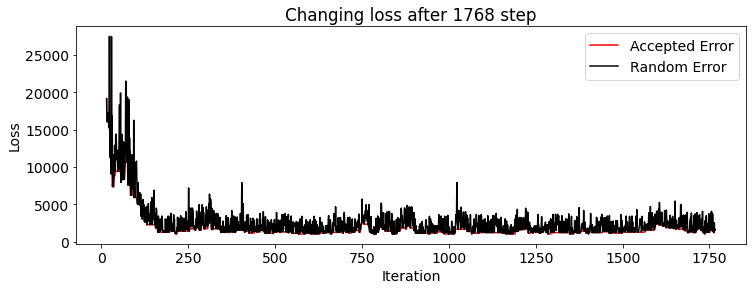

In [4]:
run_data = T.run_data
rd = np.array(run_data)
errors = T.get_errors()

new_acc_errors = []
new_random_errors = []
for i, t in enumerate(rd):
    rnd = np.random.rand()
    if t[-1] > rnd/10000:
        new_acc_errors.append(errors[i])
        new_random_errors.append(t[-2])
        
plt.figure(figsize=(12, 4))
plt.plot(new_acc_errors[1:], 'r', label='Accepted Error') # accepted errors
plt.plot(new_random_errors, 'k', label='Random Error') # random errors
# plt.plot(self.enrgs) # best errors
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Changing loss after {} step'.format(len(new_random_errors)))
# if filename:
#     plt.savefig(filename)
plt.show()

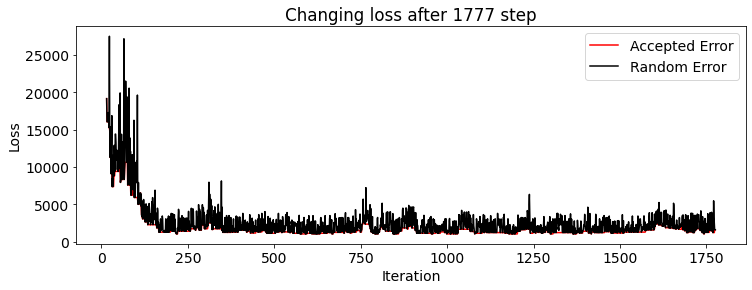

In [5]:
run_data = T.run_data
rd = np.array(run_data)
errors = T.get_errors()

new_acc_errors = []
new_random_errors = []
for i, t in enumerate(rd):
    rnd = np.random.rand()
    if t[-1] > rnd/10000:
        new_acc_errors.append(errors[i])
        new_random_errors.append(t[-2])
        
plt.figure(figsize=(12, 4))
plt.plot(new_acc_errors[1:], 'r', label='Accepted Error') # accepted errors
plt.plot(new_random_errors, 'k', label='Random Error') # random errors
# plt.plot(self.enrgs) # best errors
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Changing loss after {} step'.format(len(new_random_errors)))
# if filename:
#     plt.savefig(filename)
plt.show()

In [6]:
import json
with open('./pw/data_fix_M_and_N_change.json', 'w', encoding='utf-8') as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

### The effect of changing $M$ for fixed $\frac{M}{N}$ ratio

In [7]:
M, N = 10, 50
ZETA = 1
Gamma = 0.15
alpha = 6*1e-6
beta = 0.15
MR = 0.00


all_result = []
for M in [10, 15, 20, 30]:
    N = int(M*1.2)
    means_pwd = []
    best_engs = []
    varia_pwd = []
    pwae = []
    print(f'started with params: M={M}, N={N}')
    for rond in range(7):
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
        gensNames = list( str(i) for i in range(M) )
        C_num = D.shape[1]
        G_num = D.shape[0]
#         _.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        ### Fill missed data
        def tf(m,c):
            os = len(np.where(D[:,c]==1.))*1.
            zs = len(np.where(D[:,c]==0.))*1.
            return 1. if np.random.rand() < os/(os+zs) else 0.

        for m in range(G_num):
            for c in range(C_num):
                if D[m,c] == 3.:
                    D[m,c] = tf(m,c)
        ### Run
        dl = list(d for d in D)
        root = [n for n,d in gt_T.in_degree() if d==0][0]
#         print('ROOT:', root)
        T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
        T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)
        T.randomize()
        # T.plot_best_T('initial T'); T.plot('T0')
        T.set_rho(15)
        for i in range(5000):
            if T.next():
                break
                
        ###  Benchmarking
        pwae.append(pairwise_anc_error(T.gt_T, T.get_best_tree()))
        best_T = T.get_best_tree()
        best_g = best_T.to_undirected()
        gt_T = T.gt_T
        gt_T = gt_T.to_undirected()
        best_pair_dists = dict(nx.all_pairs_shortest_path_length(best_g))
        gt_pair_dists   = dict(nx.all_pairs_shortest_path_length(gt_T  ))
        diffs = []
        for i in range(M-1):
            for j in range(i+1, M):
                best_dis = best_pair_dists[str(i)][str(j)]
                gt_dis   = gt_pair_dists  [i][j]
                diff = abs(best_dis - gt_dis)
                diffs.append(diff)
        means_pwd.append(np.mean(diffs))
        varia_pwd.append(np.var(diffs))
        best_engs.append(T.get_best_error())
        print(f'\trond={rond}, mean_pwd={means_pwd[-1]:0.4f}, varia_pwd={varia_pwd[-1]:0.4f}, best_eng={best_engs[-1]:0.4f}')
        
    all_result.append({
        'params': {
            'M':M,
            'N':N, 
            'ZETA':ZETA,
            'Gamma':Gamma,
            'alpha':alpha,
            'beta':beta,
            'MR':MR,
        },
        'means_pwd': means_pwd,
        'varia_pwd': varia_pwd,
        'best_engs': best_engs,
        'pwae': pwae
    })
    print(38*'-~')
    print(f'\tAVG_mean_pwd={np.mean(means_pwd):0.4f}, AVG_varia_pwd={np.mean(varia_pwd):0.4f}, AVG_best_eng={np.mean(best_engs):0.4f}, AVG_pwae={np.mean(pwae):0.4f}\n\n')
#     T.plot_eng_chart()

import json
with open('./pw/data_fix_MoverN_ratio_and_M_change.json', 'w', encoding='utf-8') as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

started with params: M=10, N=12
	rond=0, mean_pwd=1.4000, varia_pwd=1.1733, best_eng=88.3320
	rond=1, mean_pwd=1.0889, varia_pwd=0.9699, best_eng=44.8698
	rond=2, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=89.0643
	rond=3, mean_pwd=0.6889, varia_pwd=0.3477, best_eng=104.7319
	rond=4, mean_pwd=0.6222, varia_pwd=0.5017, best_eng=77.7011
	rond=5, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=72.8906
	rond=6, mean_pwd=0.3556, varia_pwd=0.2291, best_eng=99.4078
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.6444, AVG_varia_pwd=0.4930, AVG_best_eng=82.4282, AVG_pwae=0.1841


started with params: M=15, N=18
	rond=0, mean_pwd=0.1333, varia_pwd=0.1156, best_eng=292.4559
	rond=1, mean_pwd=0.6857, varia_pwd=0.3679, best_eng=331.0355
	rond=2, mean_pwd=0.6095, varia_pwd=0.3332, best_eng=227.6555
	rond=3, mean_pwd=1.4095, varia_pwd=2.1656, best_eng=167.1896
	rond=4, mean_pwd=1.1619, varia_pwd=1.9071, best_eng=187.7326
	rond=5, mean_pwd=0.8571, varia_pwd=0

/home/afshin/Desktop/itmt/src/ds.py:638: RuntimeWarning: divide by zero encountered in log
  np.log(self.beta **fn_cnt + ep) +\


	rond=0, mean_pwd=4.1241, varia_pwd=10.9915, best_eng=10708.1642
	rond=1, mean_pwd=3.2000, varia_pwd=6.7899, best_eng=10028.7201
	rond=2, mean_pwd=5.3954, varia_pwd=18.5793, best_eng=inf
	rond=3, mean_pwd=5.1494, varia_pwd=18.4857, best_eng=11299.1683
	rond=4, mean_pwd=5.5931, varia_pwd=22.3011, best_eng=inf
	rond=5, mean_pwd=4.7425, varia_pwd=14.1820, best_eng=13869.2184
	rond=6, mean_pwd=4.0966, varia_pwd=9.5631, best_eng=11703.2114
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=4.6144, AVG_varia_pwd=14.4132, AVG_best_eng=inf, AVG_pwae=0.4299




### The effect of changing $\alpha$ for fixed other params

In [8]:
M, N = 12, 16
ZETA = 1
Gamma = 0.15
alpha = 6*1e-6
beta = 0.05
MR = 0.00


all_result = []
for alpha in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    means_pwd = []
    best_engs = []
    varia_pwd = []
    pwae = []
    print(f'started with params: M={M}, N={N}')
    for rond in range(7):
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
        gensNames = list( str(i) for i in range(M) )
        C_num = D.shape[1]
        G_num = D.shape[0]
#         _.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        ### Fill missed data
        def tf(m,c):
            os = len(np.where(D[:,c]==1.))*1.
            zs = len(np.where(D[:,c]==0.))*1.
            return 1. if np.random.rand() < os/(os+zs) else 0.

        for m in range(G_num):
            for c in range(C_num):
                if D[m,c] == 3.:
                    D[m,c] = tf(m,c)
        ### Run
        dl = list(d for d in D)
        root = [n for n,d in gt_T.in_degree() if d==0][0]
#         print('ROOT:', root)
        T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
        T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)
        T.randomize()
        # T.plot_best_T('initial T'); T.plot('T0')
        T.set_rho(15)
        for i in range(5000):
            if T.next():
                break
                
        ###  Benchmarking
        pwae.append(pairwise_anc_error(T.gt_T, T.get_best_tree()))
        best_T = T.get_best_tree()
        best_g = best_T.to_undirected()
        gt_T = T.gt_T
        gt_T = gt_T.to_undirected()
        best_pair_dists = dict(nx.all_pairs_shortest_path_length(best_g))
        gt_pair_dists   = dict(nx.all_pairs_shortest_path_length(gt_T  ))
        diffs = []
        for i in range(M-1):
            for j in range(i+1, M):
                best_dis = best_pair_dists[str(i)][str(j)]
                gt_dis   = gt_pair_dists  [i][j]
                diff = abs(best_dis - gt_dis)
                diffs.append(diff)
        means_pwd.append(np.mean(diffs))
        varia_pwd.append(np.var(diffs))
        best_engs.append(T.get_best_error())
        print(f'\trond={rond}, mean_pwd={means_pwd[-1]:0.4f}, varia_pwd={varia_pwd[-1]:0.4f}, best_eng={best_engs[-1]:0.4f}')
        
    all_result.append({
        'params': {
            'M':M,
            'N':N, 
            'ZETA':ZETA,
            'Gamma':Gamma,
            'alpha':alpha,
            'beta':beta,
            'MR':MR,
        },
        'means_pwd': means_pwd,
        'varia_pwd': varia_pwd,
        'best_engs': best_engs,
        'pwae': pwae
    })
    print(38*'-~')
    print(f'\tAVG_mean_pwd={np.mean(means_pwd):0.4f}, AVG_varia_pwd={np.mean(varia_pwd):0.4f}, AVG_best_eng={np.mean(best_engs):0.4f}, AVG_pwae={np.mean(pwae):0.4f}\n\n')
#     T.plot_eng_chart()

import json
with open('./pw/data_fix_param_alpha_change.json', 'w', encoding='utf-8') as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

started with params: M=12, N=16
	rond=0, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=49.6083
	rond=1, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=60.2481
	rond=2, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=32.5648
	rond=3, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=120.1983
	rond=4, mean_pwd=0.4394, varia_pwd=0.2766, best_eng=8.4691
	rond=5, mean_pwd=0.5303, varia_pwd=0.2491, best_eng=55.1940
	rond=6, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=27.5440
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.3550, AVG_varia_pwd=0.2260, AVG_best_eng=50.5466, AVG_pwae=0.0823


started with params: M=12, N=16
	rond=0, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=39.7937
	rond=1, mean_pwd=0.5455, varia_pwd=0.3085, best_eng=40.3201
	rond=2, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=42.9864
	rond=3, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=16.5141
	rond=4, mean_pwd=0.4091, varia_pwd=0.2417, best_eng=31.8353
	rond=5, mean_pwd=0.5303, varia_pwd=0.2491,

### The effect of changing $\beta$ for fixed other params

In [9]:
M, N = 12, 16
ZETA = 1
Gamma = 0.15
alpha = 1e-5
beta = 0.15
MR = 0.00


all_result = []
for beta in [0.01, 0.03, 0.06, 0.1, 0.16, 0.25]:
    means_pwd = []
    best_engs = []
    varia_pwd = []
    pwae = []
    print(f'started with params: M={M}, N={N}')
    for rond in range(7):
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
        gensNames = list( str(i) for i in range(M) )
        C_num = D.shape[1]
        G_num = D.shape[0]
#         _.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        ### Fill missed data
        def tf(m,c):
            os = len(np.where(D[:,c]==1.))*1.
            zs = len(np.where(D[:,c]==0.))*1.
            return 1. if np.random.rand() < os/(os+zs) else 0.

        for m in range(G_num):
            for c in range(C_num):
                if D[m,c] == 3.:
                    D[m,c] = tf(m,c)
        ### Run
        dl = list(d for d in D)
        root = [n for n,d in gt_T.in_degree() if d==0][0]
#         print('ROOT:', root)
        T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
        T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)
        T.randomize()
        # T.plot_best_T('initial T'); T.plot('T0')
        T.set_rho(15)
        for i in range(5000):
            if T.next():
                break
                
        ###  Benchmarking
        pwae.append(pairwise_anc_error(T.gt_T, T.get_best_tree()))
        best_T = T.get_best_tree()
        best_g = best_T.to_undirected()
        gt_T = T.gt_T
        gt_T = gt_T.to_undirected()
        best_pair_dists = dict(nx.all_pairs_shortest_path_length(best_g))
        gt_pair_dists   = dict(nx.all_pairs_shortest_path_length(gt_T  ))
        diffs = []
        for i in range(M-1):
            for j in range(i+1, M):
                best_dis = best_pair_dists[str(i)][str(j)]
                gt_dis   = gt_pair_dists  [i][j]
                diff = abs(best_dis - gt_dis)
                diffs.append(diff)
        means_pwd.append(np.mean(diffs))
        varia_pwd.append(np.var(diffs))
        best_engs.append(T.get_best_error())
        print(f'\trond={rond}, mean_pwd={means_pwd[-1]:0.4f}, varia_pwd={varia_pwd[-1]:0.4f}, best_eng={best_engs[-1]:0.4f}')
        
    all_result.append({
        'params': {
            'M':M,
            'N':N, 
            'ZETA':ZETA,
            'Gamma':Gamma,
            'alpha':alpha,
            'beta':beta,
            'MR':MR,
        },
        'means_pwd': means_pwd,
        'varia_pwd': varia_pwd,
        'best_engs': best_engs,
        'pwae': pwae
    })
    print(38*'-~')
    print(f'\tAVG_mean_pwd={np.mean(means_pwd):0.4f}, AVG_varia_pwd={np.mean(varia_pwd):0.4f}, AVG_best_eng={np.mean(best_engs):0.4f}, AVG_pwae={np.mean(pwae):0.4f}\n\n')
#     T.plot_eng_chart()

import json
with open('./pw/data_fix_param_beta_change.json', 'w', encoding='utf-8') as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

started with params: M=12, N=16
	rond=0, mean_pwd=0.4848, varia_pwd=0.2498, best_eng=0.8332
	rond=1, mean_pwd=1.0000, varia_pwd=3.4848, best_eng=0.8332
	rond=2, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=0.4934
	rond=3, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=0.7225
	rond=4, mean_pwd=0.6667, varia_pwd=0.4040, best_eng=13.0071
	rond=5, mean_pwd=0.5455, varia_pwd=0.2479, best_eng=56.7708
	rond=6, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=0.5295
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.4719, AVG_varia_pwd=0.6870, AVG_best_eng=10.4557, AVG_pwae=0.1017


started with params: M=12, N=16
	rond=0, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=31.3298
	rond=1, mean_pwd=0.1667, varia_pwd=0.1389, best_eng=30.7556
	rond=2, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=16.8935
	rond=3, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=13.0699
	rond=4, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=31.9075
	rond=5, mean_pwd=0.0000, varia_pwd=0.0000, best

### The effect of changing $MR$ for fixed other params

In [10]:
M, N = 12, 16
ZETA = 1
Gamma = 0.15
alpha = 1e-5
beta = 0.05
MR = 0.00


all_result = []
for MR in [0, 0.01, 0.02, 0.05, 0.1]:
    means_pwd = []
    best_engs = []
    varia_pwd = []
    pwae = []
    print(f'started with params: M={M}, N={N}')
    for rond in range(7):
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
        gensNames = list( str(i) for i in range(M) )
        C_num = D.shape[1]
        G_num = D.shape[0]
#         _.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        ### Fill missed data
        def tf(m,c):
            os = len(np.where(D[:,c]==1.))*1.
            zs = len(np.where(D[:,c]==0.))*1.
            return 1. if np.random.rand() < os/(os+zs) else 0.

        for m in range(G_num):
            for c in range(C_num):
                if D[m,c] == 3.:
                    D[m,c] = tf(m,c)
        ### Run
        dl = list(d for d in D)
        root = [n for n,d in gt_T.in_degree() if d==0][0]
#         print('ROOT:', root)
        T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
        T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)
        T.randomize()
        # T.plot_best_T('initial T'); T.plot('T0')
        T.set_rho(15)
        for i in range(5000):
            if T.next():
                break
                
        ###  Benchmarking
        pwae.append(pairwise_anc_error(T.gt_T, T.get_best_tree()))
        best_T = T.get_best_tree()
        best_g = best_T.to_undirected()
        gt_T = T.gt_T
        gt_T = gt_T.to_undirected()
        best_pair_dists = dict(nx.all_pairs_shortest_path_length(best_g))
        gt_pair_dists   = dict(nx.all_pairs_shortest_path_length(gt_T  ))
        diffs = []
        for i in range(M-1):
            for j in range(i+1, M):
                best_dis = best_pair_dists[str(i)][str(j)]
                gt_dis   = gt_pair_dists  [i][j]
                diff = abs(best_dis - gt_dis)
                diffs.append(diff)
        means_pwd.append(np.mean(diffs))
        varia_pwd.append(np.var(diffs))
        best_engs.append(T.get_best_error())
        print(f'\trond={rond}, mean_pwd={means_pwd[-1]:0.4f}, varia_pwd={varia_pwd[-1]:0.4f}, best_eng={best_engs[-1]:0.4f}')
        
    all_result.append({
        'params': {
            'M':M,
            'N':N, 
            'ZETA':ZETA,
            'Gamma':Gamma,
            'alpha':alpha,
            'beta':beta,
            'MR':MR,
        },
        'means_pwd': means_pwd,
        'varia_pwd': varia_pwd,
        'best_engs': best_engs,
        'pwae': pwae
    })
    print(38*'-~')
    print(f'\tAVG_mean_pwd={np.mean(means_pwd):0.4f}, AVG_varia_pwd={np.mean(varia_pwd):0.4f}, AVG_best_eng={np.mean(best_engs):0.4f}, AVG_pwae={np.mean(pwae):0.4f}\n\n')
#     T.plot_eng_chart()

import json
with open('./pw/data_fix_param_MR_change.json', 'w', encoding='utf-8') as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

started with params: M=12, N=16
	rond=0, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=118.3130
	rond=1, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=99.7944
	rond=2, mean_pwd=0.4091, varia_pwd=0.2417, best_eng=104.8311
	rond=3, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=68.5778
	rond=4, mean_pwd=0.4091, varia_pwd=0.2417, best_eng=5.4025
	rond=5, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=15.9299
	rond=6, mean_pwd=0.3030, varia_pwd=0.2112, best_eng=109.2137
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
	AVG_mean_pwd=0.3333, AVG_varia_pwd=0.2199, AVG_best_eng=74.5804, AVG_pwae=0.0801


started with params: M=12, N=16
	rond=0, mean_pwd=0.0000, varia_pwd=0.0000, best_eng=85.0495
	rond=1, mean_pwd=0.6515, varia_pwd=0.3483, best_eng=135.0165
	rond=2, mean_pwd=0.3030, varia_pwd=0.5142, best_eng=19.3312
	rond=3, mean_pwd=0.6212, varia_pwd=0.4474, best_eng=110.6878
	rond=4, mean_pwd=0.5303, varia_pwd=0.2491, best_eng=6.6618
	rond=5, mean_pwd=0.3333, varia_pwd=0.25